In [1]:
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['c:\\Users\\anaxa\\Documents\\Projects\\BAMT', 'c:\\Users\\anaxa\\Documents\\Projects', 'c:\\Users\\anaxa\\Documents\\Projects\\BAMT\\tutorials']


In [13]:
import bamt.Networks as Nets
import bamt.Preprocessors as pp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from bamt.Builders import StructureBuilder

from pgmpy.estimators import K2Score
from gmr import GMM
import seaborn as sns

In [4]:
data = pd.read_csv(r'../Data/hack_processed_with_rf.csv')
data

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,...,Period,Lithology,Gross,Netpay,Porosity,Permeability,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor
0,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,...,JURASSIC,LIMESTONE,75.0,55.2,21.0,410.0,839.762611,NaN,NaN,NaN
1,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,ONSHORE,...,CRETACEOUS,SANDSTONE,223.5,43.2,10.0,8.0,NaN,NaN,NaN,0.84
2,ABU MADI-EL QARA,ABU MADI (LEVEL II),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,...,NEOGENE,THINLY-BEDDED SANDSTONE,34.5,19.8,22.0,200.0,NaN,NaN,NaN,0.75
3,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,...,NEOGENE,SANDSTONE,152.7,123.0,20.0,300.0,779.614325,NaN,NaN,0.78
4,AL HUWAISAH,SHUAIBA,OMAN,MIDDLE EAST,FAHUD SALT,COMPRESSION,21.9607,56.0452,PDO,ONSHORE,...,CRETACEOUS,LIMESTONE,75.0,30.0,21.0,60.0,825.072886,0.26,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,ZAOYUAN,KONGDIAN-1 (ZILAITUN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,...,PALEOGENE,SANDSTONE,49.2,18.6,23.2,121.0,946.488294,0.13,NaN,NaN
510,ZAOYUAN,KONGDIAN-2 (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,NaN,38.2100,117.0600,PETROCHINA,ONSHORE,...,PALEOGENE,SANDSTONE,88.5,23.7,NaN,60.0,881.619938,0.19,NaN,NaN
511,ZAOYUAN,UNNAMED (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,...,MESOZOIC,VOLCANICS,147.6,58.2,12.7,3.6,870.769231,0.05,NaN,NaN
512,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,...,CARBONIFEROUS,SANDSTONE,78.6,9.9,24.0,30.0,887.147335,0.24,NaN,NaN


In [5]:
cols = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[cols]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [6]:
data.head(10)

,Tectonic regime,Period,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth
0,COMPRESSION,JURASSIC,LIMESTONE,FORELAND,75.0,55.2,21.0,410.0,1815.0
1,EXTENSION,CRETACEOUS,SANDSTONE,RIFT,223.5,43.2,10.0,8.0,3084.6
2,STRIKE-SLIP,NEOGENE,THINLY-BEDDED SANDSTONE,WRENCH,34.5,19.8,22.0,200.0,2952.9
3,STRIKE-SLIP,NEOGENE,SANDSTONE,WRENCH,152.7,123.0,20.0,300.0,3149.7
4,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,75.0,30.0,21.0,60.0,1486.5
5,GRAVITY,CRETACEOUS,LIMESTONE,PASSIVE MARGIN,28.5,4.5,12.0,20.0,2610.0
6,COMPRESSION,CARBONIFEROUS,LIMESTONE,SUB-SALT,90.0,31.5,10.0,20.0,1800.0
7,COMPRESSION,CARBONIFEROUS,LIMESTONE,SUB-SALT,182.1,32.4,10.0,20.0,2874.0
8,COMPRESSION,JURASSIC,SANDSTONE,FORELAND,15.0,14.7,20.0,15.0,1980.0
9,COMPRESSION,PALEOGENE,SANDSTONE,FORELAND,2400.0,172.5,5.0,0.1,4575.0


In [7]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(data)

In [15]:
bn = Nets.HybridBN(has_logit=True, use_mixture=True) # init BN
info = p.info
info

{'types': {'Tectonic regime': 'disc',
  'Period': 'disc',
  'Lithology': 'disc',
  'Structural setting': 'disc',
  'Gross': 'cont',
  'Netpay': 'cont',
  'Porosity': 'cont',
  'Permeability': 'cont',
  'Depth': 'cont'},
 'signs': {'Gross': 'pos',
  'Netpay': 'pos',
  'Porosity': 'pos',
  'Permeability': 'pos',
  'Depth': 'pos'}}

In [16]:
bn.add_nodes(info)

In [17]:
structure = [('Tectonic regime', 'Structural setting'), ('Gross', 'Netpay'), ('Lithology', 'Permeability')]

In [19]:
tmp = StructureBuilder(info)
tmp.skeleton = {
    'V': bn.nodes,
    'E': structure
}
tmp.get_family()

bn.nodes = tmp.skeleton['V']
bn.edges = tmp.skeleton['E']


In [20]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,Discrete,disc,[],[]
2,Lithology,Discrete,disc,[],[]
3,Structural setting,Discrete,disc,[Tectonic regime],[disc]
4,Gross,Gaussian,cont,[],[]
5,Netpay,Gaussian,cont,[Gross],[cont]
6,Porosity,Gaussian,cont,[],[]
7,Permeability,Gaussian,cont,[Lithology],[disc]
8,Depth,Gaussian,cont,[],[]


In [43]:
bn.add_nodes(info)
bn.add_edges(discretized_data,  scoring_function=('K2',K2Score))

  0%|          | 11/1000000 [00:01<28:30:37,  9.74it/s]


In [44]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,Discrete,disc,[Structural setting],[disc]
2,Lithology,Discrete,disc,[],[]
3,Structural setting,Discrete,disc,[Tectonic regime],[disc]
4,Gross,ConditionalGaussian,cont,"[Period, Lithology, Structural setting]","[disc, disc, disc]"
5,Netpay,Gaussian,cont,[Gross],[cont]
6,Porosity,ConditionalGaussian,cont,[Period],[disc]
7,Permeability,ConditionalGaussian,cont,"[Porosity, Lithology]","[cont, disc]"
8,Depth,ConditionalGaussian,cont,"[Porosity, Structural setting]","[cont, disc]"


In [45]:
bn.fit_parameters(data)

In [46]:
bn.get_params_tree('geo_params.json')

True

In [47]:
test = data[['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay', 'Porosity','Permeability']]

In [48]:
val_pred = bn.predict(test, 11)

100%|██████████| 442/442 [00:02<00:00, 208.58it/s]


In [49]:
val_pred

{'Depth': [1406.9833920752726,
  2930.7216633260514,
  1909.09547389795,
  2147.3195650749985,
  2510.037063011833,
  2420.1189539489314,
  2880.221746311385,
  2880.221746311385,
  1479.1301261976564,
  2561.3311380334117,
  2439.825824998829,
  2685.27374416244,
  1613.2776127488669,
  2595.291199324791,
  1658.4882486728882,
  2369.69784809494,
  2028.2075194864742,
  2407.6814768738614,
  1726.30420255892,
  1176.3667248603356,
  2461.5210544692736,
  1742.749836195214,
  2425.800229618051,
  2299.569871191051,
  2720.3377326143845,
  3362.57842614141,
  2790.4657095182733,
  2124.2499289313287,
  2229.441894287162,
  2650.2097557104953,
  2046.790894076194,
  1479.1301261976564,
  2190.3377615852846,
  774.1594716152563,
  1998.5122451340872,
  1668.4180790560508,
  2448.5346647958954,
  2820.6909711517283,
  1000.6207989517297,
  1091.205329886319,
  1703.6988845969095,
  2403.9755450341327,
  865.8828861573952,
  1695.5703285648074,
  2439.825824998829,
  2650.2097557104953,
  2

In [50]:
mean_squared_error(data['Depth'].values, val_pred['Depth'], squared=False)

846.9795241991144

In [51]:
sample = bn.sample(500)

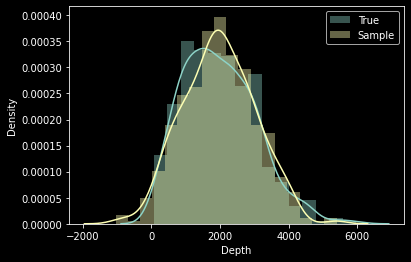

In [52]:
sns.distplot(data['Depth'], label='True')
sns.distplot(sample['Depth'], label='Sample')
plt.legend()